<a href="https://colab.research.google.com/github/swamy-surla/Data-mining-1/blob/main/Data_Mining_Programming_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import warnings

from PIL import Image
from skimage.color import rgb2gray
import xml.etree.ElementTree as ET
from skimage import io, exposure, filters

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold


import matplotlib.pyplot as plt

In [ ]:
warnings.filterwarnings("ignore")

## 1

In [ ]:
def resize_crop_image(image_path,image_filename,annotation_path,annotation_filename):
    bnd_box = []
    im = Image.open(os.path.join(image_path,image_filename))
    annotation = ET.parse(os.path.join(annotation_path,annotation_filename))
    annotation_root =  annotation.getroot()
    for child in annotation_root.findall('object')[0].findall('bndbox')[0]:
        # print(child.tag,child.text)
        bnd_box.append(int(child.text))
    im = im.crop(bnd_box)
    im = im.resize((128,128))
    return im

In [ ]:
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

In [ ]:
image_dir = "/content/drive/MyDrive/ajas/images/Images"
annotation_dir = "/content/drive/MyDrive/ajas/annotations/Annotation"

In [ ]:
class_names = "Dandie_Dinmont	Otterhound	Tibetan_terrier	French_bulldog".split("\t")

In [ ]:
class_names

['Dandie_Dinmont', 'Otterhound', 'Tibetan_terrier', 'French_bulldog']

In [ ]:
class_paths = ['n02096437-Dandie_Dinmont','n02097474-Tibetan_terrier','n02091635-otterhound','n02108915-French_bulldog']

In [ ]:
new_dir = "/content/drive/MyDrive/data_mining/Processed_images"

In [ ]:
def process_images():
  if not os.path.exists(new_dir):
    os.mkdir(new_dir)
  for class_ in class_paths:
      image_class_path = os.path.join(image_dir,class_)
      annotation_class_path = os.path.join(annotation_dir,class_)
      images = os.listdir(image_class_path)
      annotations = os.listdir(annotation_class_path)
      new_class_dir = os.path.join(new_dir,class_)
      if not os.path.exists(new_class_dir):
          os.mkdir(new_class_dir)
      for image_filename ,annotation_filename in zip(images,annotations):
          im = resize_crop_image(image_class_path,image_filename,annotation_class_path,annotation_filename)
          im.save(os.path.join(new_class_dir,image_filename))

## 2

In [ ]:
df = pd.DataFrame(columns = list(range(0,36))+['class'])
for class_ in class_paths:
  class_path = os.path.join(new_dir,class_)
  for filename in os.listdir(class_path):
    img = io.imread(os.path.join(class_path,filename))
    gray_sacle = rgb2gray(img)
    angle_sobel = angle(filters.sobel_h(gray_sacle),
                    filters.sobel_v(gray_sacle))
    hist,bins = exposure.histogram(angle_sobel,nbins=36)

    # print("here")
    for i in class_names:
      if i.lower() in class_.lower():
        break
    df.loc[len(df)] = list(hist)+[class_names.index(i)]




In [ ]:
df.to_csv("/content/drive/MyDrive/data_mining/hist_datset.csv")

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,class
0,672,600,573,553,493,443,409,362,425,432,...,419,432,430,460,518,491,486,563,613,0
1,6297,317,269,275,248,236,238,234,234,252,...,263,319,285,323,291,318,319,331,332,0
2,2251,359,301,300,267,298,293,332,360,412,...,339,270,266,273,273,279,288,294,356,0
3,678,566,590,568,481,460,462,436,410,382,...,448,427,417,467,541,565,600,611,592,0
4,441,417,409,456,410,410,405,428,455,475,...,400,426,369,383,364,429,460,432,410,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,2138,643,555,555,443,459,438,413,450,471,...,343,298,333,357,403,476,490,624,846,3
692,12055,275,227,197,169,139,121,105,86,109,...,82,98,121,117,132,178,175,237,290,3
693,4565,379,346,354,315,294,286,264,248,264,...,324,326,345,353,318,325,362,376,454,3
694,3690,439,432,385,353,349,337,334,298,362,...,427,374,364,366,362,472,415,457,600,3


## 3

In [ ]:
X = np.array(df[df.columns[:-1]])
y = np.array(df['class'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

## 4,5

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [ ]:
scalled_x_train= scaler.transform(X_train)
scalled_x_test = scaler.transform(X_test)

## 6

In [ ]:
mean_val_errors_std = []
mean_val_errors_strat = []
mean_train_errors_std = []
mean_train_errors_strat = []
k_values = [1, 3, 5, 7, 10, 20]
for k in k_values:
    # Standard 5-fold cross-validation
    kf = KFold(n_splits=5,shuffle=True,random_state=k)
    knn_1 = KNeighborsClassifier(n_neighbors=k)
    val_scores_std = cross_val_score(knn_1, scalled_x_train, y_train, cv=kf)
    train_scores_std = knn_1.fit(scalled_x_train, y_train).score(scalled_x_train, y_train)
    mean_val_errors_std.append(1 - np.mean(val_scores_std))
    mean_train_errors_std.append(1 - train_scores_std)

    knn_2 = KNeighborsClassifier(n_neighbors=k)
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=k)
    val_scores_strat = cross_val_score(knn_2, scalled_x_train, y_train, cv=skf)
    train_scores_strat = knn_2.fit(scalled_x_train, y_train).score(scalled_x_train, y_train)
    mean_val_errors_strat.append(1 - np.mean(val_scores_strat))
    mean_train_errors_strat.append(1 - train_scores_strat)


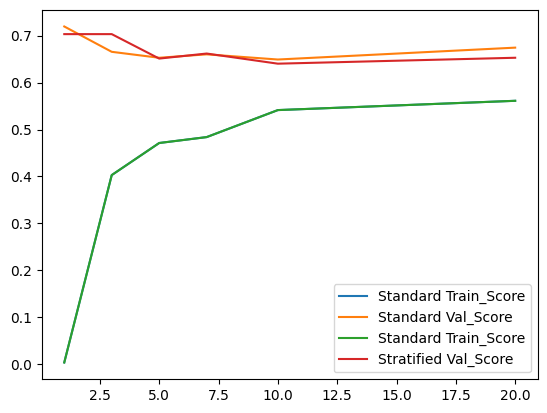

In [ ]:
fig,ax = plt.subplots()
ax.plot(k_values,mean_train_errors_std,label="Standard Train_Score")
ax.plot(k_values,mean_val_errors_std,label="Standard Val_Score")
ax.plot(k_values,mean_train_errors_strat,label="Standard Train_Score")
ax.plot(k_values,mean_val_errors_strat,label="Stratified Val_Score")
ax.legend()
plt.show()

In [ ]:
print(f"Lowest Standrad Training mean Error is {np.min(mean_train_errors_std)} at  k =  {k_values[np.argmin(mean_train_errors_std)]}")
print(f"Lowest Standrad Val mean Error is {np.min(mean_val_errors_std)}  at  k = {k_values[np.argmin(mean_val_errors_std)]}")
print(f"Lowest Stratified Training mean Error is {np.min(mean_train_errors_strat)} at k = {k_values[np.argmin(mean_train_errors_strat)]}")
print(f"Lowest Stratified Val mean Error is {np.min(mean_val_errors_strat)} at k = {k_values[np.argmin(mean_val_errors_strat)]}")

Lowest Standrad Training mean Error is 0.003597122302158251 at  k =  1
Lowest Standrad Val mean Error is 0.6491151866151866  at  k = 10
Lowest Stratified Training mean Error is 0.003597122302158251 at k = 1
Lowest Stratified Val mean Error is 0.6402509652509653 at k = 10


Overfiting at K =1 as Train error is low and val error is high.

As Stratified Val error is lowest at k = 10

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(scalled_x_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
error = 1- knn.score(scalled_x_test,y_test)

In [ ]:
error

0.6857142857142857

Test Score = 0.6857142857142857

## 7

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
classifiers = [DecisionTreeClassifier(max_depth=10),MLPClassifier(hidden_layer_sizes = (10, 10, 10, )), AdaBoostClassifier()]
classifier_names = ['Decision Tree', 'MLP','Ada Boost']

In [ ]:
val_accs = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for classifier in classifiers:
  temp = []
  for fold, (start_train_index, val_index) in enumerate(skf.split(scalled_x_train, y_train)):
    X_start_train, X_val = scalled_x_train[start_train_index], scalled_x_train[val_index]
    y_start_train, y_val = y_train[start_train_index], y_train[val_index]
    classifier.fit(X_start_train, y_start_train)
    y_pred = classifier.predict(X_val)
    temp.append(accuracy_score(y_val,y_pred))
  val_accs.append(np.mean(temp))


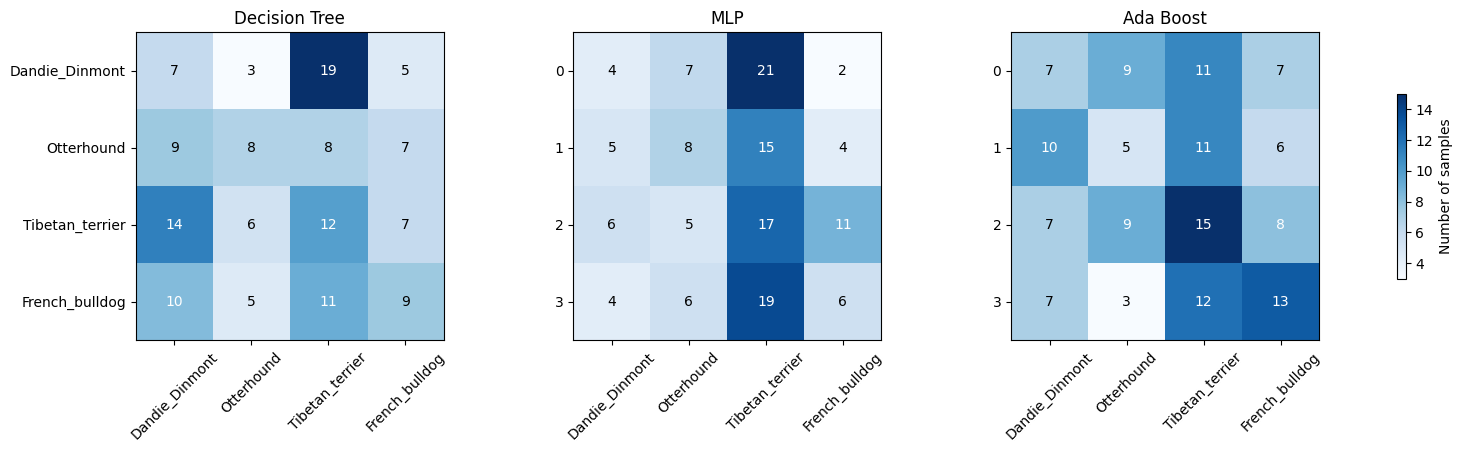

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))
ind = 0
for name, classifier in zip(classifier_names,classifiers):
  y_pred = classifier.predict(scalled_x_test)
  cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

  im = axes[ind].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)


  axes[ind].set_xticks(np.arange(len(class_names)))
  axes[ind].set_yticks(np.arange(len(class_names)))
  axes[ind].set_xticklabels(class_names,rotation=45)
  if ind==0:
    axes[ind].set_yticklabels(class_names)
  axes[ind].set_title(name)

  for i in range(len(class_names)):
      for j in range(len(class_names)):
          axes[ind].text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
  ind+=1

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.ax.set_ylabel('Number of samples')



plt.show()


## 7 a

Ada boost is the the best bases on confusion matrix visualization as it has the best values diagnally

## 7 b

In [ ]:
for clf_name, acc in zip(classifier_names,val_accs):
  print(f"{clf_name} Mean Val accuracy accross K folds {np.mean(acc)}")

Decision Tree Mean Val accuracy accross K folds 0.30572715572715575
MLP Mean Val accuracy accross K folds 0.3399292149292149
Ada Boost Mean Val accuracy accross K folds 0.3416666666666666


Ada boost is the best based on val accuracies

## 7 c,d

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
test_acc = []
f_scores = []
for clf_name, clf in zip(classifier_names,classifiers):
  clf.fit(scalled_x_train,y_train)
  y_pred = clf.predict(scalled_x_test)
  test_acc.append(accuracy_score(y_test,y_pred))
  f_scores.append(f1_score(y_test, y_pred, average='micro'))


In [ ]:
for clf_name, acc, f1 in zip(classifier_names,test_acc,f_scores):
  print(f"{clf_name} has Test accuracy  {acc} and F1 score {f1}")


Decision Tree has Test accuracy  0.29285714285714287 and F1 score 0.29285714285714287
MLP has Test accuracy  0.2857142857142857 and F1 score 0.2857142857142857
Ada Boost has Test accuracy  0.32142857142857145 and F1 score 0.32142857142857145


Ada boost is best in both Test accuracy and F1 score